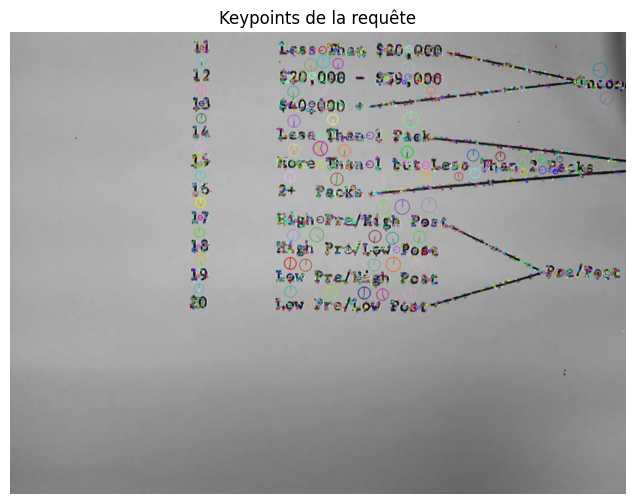

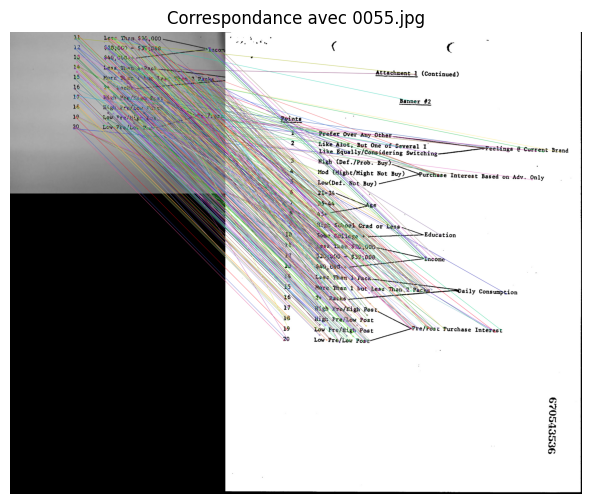

📄 Document reconnu : 0055.jpg


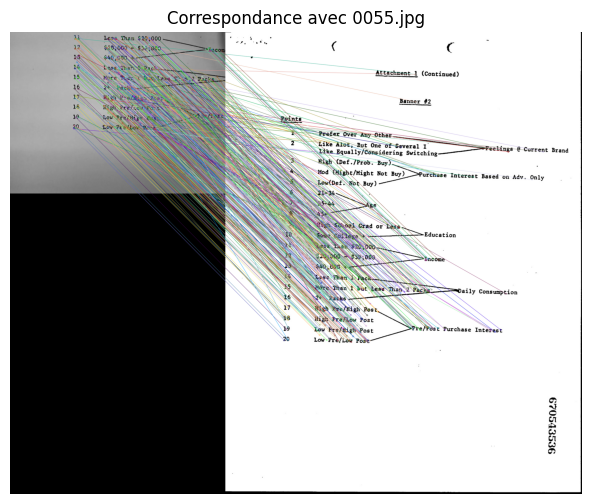

In [ ]:
import cv2
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# --- SIFT extractor ---
sift = cv2.SIFT_create()

def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return image, keypoints, descriptors

# --- Chargement dataset ---
def load_dataset_features(folder_path):
    features = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img, kp, des = extract_sift_features(path)
            features[filename] = {'image': img, 'keypoints': kp, 'descriptors': des}
    return features

# --- Extraire une frame depuis une vidéo ---
def extract_frame_from_video(video_path, frame_index=30):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return gray
    return None

# --- Affichage keypoints ---
def show_keypoints(image, keypoints, title="Keypoints"):
    img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.imshow(img_kp, cmap='gray')
    plt.axis('off')
    plt.show()

# --- Matcher avec FLANN ---
def match_query_to_dataset(query_des, dataset_features):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    match_counts = {}
    for name, data in dataset_features.items():
        if data['descriptors'] is not None and len(data['descriptors']) >= 2:
            # On cherche pour chaque descripteur de l’image requête les 2 plus proches voisins dans les descripteurs de l’image du dataset.
            matches = flann.knnMatch(query_des, data['descriptors'], k=2)
            # Cela permet d’éliminer les fausses correspondances. On garde un match seulement si le premier voisin est beaucoup plus proche que le second (rapport des distances < 0.7).
            good = [m for m, n in matches if m.distance < 0.7 * n.distance]
            match_counts[name] = len(good)
    return match_counts

# --- Visualisation des matches entre la requête et la meilleure image ---
def show_best_match(query_img, query_kp, query_des, dataset_features, best_match_name):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    best_data = dataset_features[best_match_name]
    matches = flann.knnMatch(query_des, best_data['descriptors'], k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    match_img = cv2.drawMatchesKnn(query_img, query_kp,
                                    best_data['image'], best_data['keypoints'],
                                    [[m] for m in good], None, flags=2)

    plt.figure(figsize=(12, 6))
    plt.title(f"Correspondance avec {best_match_name}")
    plt.imshow(match_img)
    plt.axis('off')
    plt.show()

def find_best_match(query_img, query_kp, query_des, dataset_features):
    best_match_name = None
    max_good_matches = 0

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    for img_name, data in dataset_features.items():
        matches = flann.knnMatch(query_des, data['descriptors'], k=2)
        good = [m for m, n in matches if m.distance < 0.7 * n.distance]
        # On garde en mémoire le nom de l’image du dataset qui a le plus de bons matchs.
        if len(good) > max_good_matches:
            max_good_matches = len(good)
            best_match_name = img_name

    return best_match_name



# --- Démo d'exécution ---
dataset_folder = "images"
video_path = "requetes/55-BL.mp4"

# 1. Indexer les images
dataset_features = load_dataset_features(dataset_folder)

# 2. Extraire une frame et les features
query_img = extract_frame_from_video(video_path, frame_index=30)
query_kp, query_des = sift.detectAndCompute(query_img, None)

# 3. Afficher les keypoints de la requête
show_keypoints(query_img, query_kp, title="Keypoints de la requête")

# 4. Comparaison avec le dataset
match_counts = match_query_to_dataset(query_des, dataset_features)
best_match = find_best_match(query_img, query_kp, query_des, dataset_features)
show_best_match(query_img, query_kp, query_des, dataset_features, best_match)
print("📄 Document reconnu :", best_match)

# 5. Afficher la comparaison visuelle
show_best_match(query_img, query_kp, query_des, dataset_features, best_match)
